<a href="https://colab.research.google.com/github/vibhutir/Melanoma-Detection-with-Domain-Specific-Artifact-Debiasing-and-Augmentation/blob/main/Medical_Marker_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

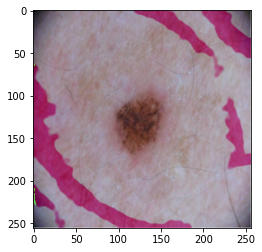

In [ ]:
import cv2
import numpy as np
import skimage.exposure
import random
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as albu

# read image
img = cv2.imread('ISIC_0000012.png')
img = cv2.resize(img,(256,256))

mm_array = np.load('mm_array.npy')

GT = cv2.imread('ISIC_0000012_segmentation.png')
GT = cv2.bitwise_not(cv2.cvtColor(GT,cv2.COLOR_BGR2GRAY))
GT = cv2.resize(GT,(256,256))

def mm_aug(image,GT,mm_array):
  colormap = np.array([[104,43,159],[191,64,191],[106,51,170],[211,63,93],[99,41,112]])
  desired_color = colormap[random.randint(0,4)]

  mask = mm_array[random.randint(0,13)].astype('uint8')
  aug_transformer = albu.Compose([albu.HorizontalFlip(p=0.5),albu.VerticalFlip(p=0.5),albu.ShiftScaleRotate(rotate_limit=[-45,45],scale_limit=[-0.1,0.1], shift_limit=[-0.1,0.15],border_mode=3,p=1.)])
  mask = aug_transformer(image = mask)['image']

  final_mask = cv2.bitwise_and(GT,GT, mask = mask)
  
  swatch = np.full((256,256,3), desired_color, dtype=np.uint8)

  facemask = final_mask

  ave_color = cv2.mean(image,mask=facemask)[:3]

  diff_color = desired_color - ave_color
  diff_color = np.full_like(image, diff_color, dtype=np.uint8)

  # shift input image color
  new_img = image+diff_color

  # antialias mask, convert to float in range 0 to 1 and make 3-channels
  facemask = cv2.GaussianBlur(facemask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
  facemask = skimage.exposure.rescale_intensity(facemask, in_range=(100,150), out_range=(0,1)).astype(np.float32)
  facemask = cv2.merge([facemask,facemask,facemask])

  # combine img and new_img using mask
  result = image * (1-facemask) + new_img * (facemask)
  result = result.clip(0,255).astype(np.uint8)
  return result

result = mm_aug(img,GT,mm_array)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

NameError: ignored

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as albu
import tensorflow as tf

# Extracting MM mask from image

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def mm_extract(image_path,blue=120,red=150):
  img = cv2.imread(image_path)
  img = cv2.resize(img,(256,256))
  ## convert to hsv
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  ## mask of green (36,25,25) ~ (86, 255,255)
  mask = cv2.inRange(hsv, (blue, 0, 0), (255, 255,red))

  ## slice the purple
  imask = mask>0
  purple = np.zeros_like(img, np.uint8)
  purple[imask] = img[imask]

  graymask = cv2.cvtColor(purple,cv2.COLOR_BGR2GRAY)
  thresh = 30
  im_bw = cv2.threshold(graymask, thresh, 255, cv2.THRESH_BINARY)[1]

  #filename = image_path.split('.')[0]+'_segmented.png'
  #cv2.imwrite(filename, im_bw)
  return im_bw

base = 'drive/MyDrive/EECS 545/mm_masks'
mm_array = np.zeros((14,256,256))
for i,img in enumerate(os.listdir(base)):
  img_path = os.path.join(base,img)
  mm_array[i] = mm_extract(img_path)

In [ ]:
np.save('mm_array.npy',mm_array)

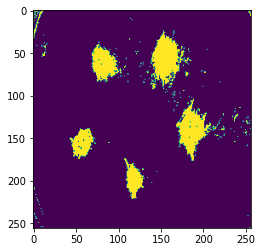

In [ ]:
import cv2
import numpy as np
import skimage.exposure
import random
import matplotlib.pyplot as plt
import pandas as pd

mm_array = np.load('mm_array.npy')
mask = mm_array[random.randint(0,13)].astype('uint8')

colormap = np.array([[104,43,159],[191,64,191],[106,51,170],[32,0,128]])
desired_color = colormap[random.randint(0,3)]

GT = cv2.imread('ISIC_0000012_segmentation.png')
GT = cv2.bitwise_not(cv2.cvtColor(GT,cv2.COLOR_BGR2GRAY))
GT = cv2.resize(GT,(256,256))

final_mask = cv2.bitwise_and(GT,GT, mask = mask)
plt.imshow(final_mask)

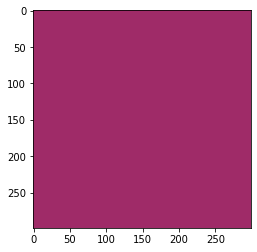

In [ ]:
plt.imshow(cv2.cvtColor(swatch,cv2.COLOR_BGR2RGB))

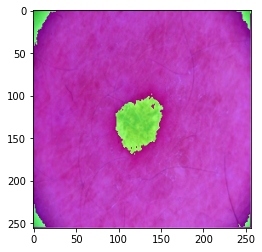

In [ ]:
plt.imshow(cv2.cvtColor(img+diff_color,cv2.COLOR_BGR2RGB))

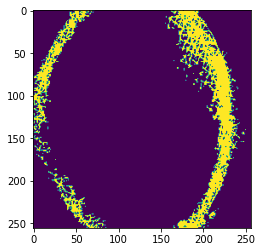

In [ ]:
plt.imshow(final_mask)

In [ ]:
import cv2
import numpy as np
import skimage.exposure

# specify desired bgr color for new face and make into array
desired_color = (180, 128, 200)
desired_color = np.asarray(desired_color, dtype=np.float64)

# create swatch
swatch = np.full((200,200,3), desired_color, dtype=np.uint8)

# read image
img = cv2.imread("zelda1.jpg")

# read face mask as grayscale and threshold to binary
facemask = cv2.imread("zelda1_facemask.png", cv2.IMREAD_GRAYSCALE)
facemask = cv2.threshold(facemask, 128, 255, cv2.THRESH_BINARY)[1]

# get average bgr color of face
ave_color = cv2.mean(img, mask=facemask)[:3]
print(ave_color)

# compute difference colors and make into an image the same size as input
diff_color = desired_color - ave_color
diff_color = np.full_like(img, diff_color, dtype=np.uint8)

# shift input image color
# cv2.add clips automatically
new_img = cv2.add(img, diff_color)

# antialias mask, convert to float in range 0 to 1 and make 3-channels
facemask = cv2.GaussianBlur(facemask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
facemask = skimage.exposure.rescale_intensity(facemask, in_range=(100,150), out_range=(0,1)).astype(np.float32)
facemask = cv2.merge([facemask,facemask,facemask])

# combine img and new_img using mask
result = (img * (1 - facemask) + new_img * facemask)
result = result.clip(0,255).astype(np.uint8)

# save result
cv2.imwrite('zelda1_swatch.png', swatch)
cv2.imwrite('zelda1_recolor.png', result)

In [ ]:
def mm_aug(mm_array,image,GT):
  mask = mm_array[random.randint(0,14)].astype('uint8')

  GT = cv2.bitwise_not(cv2.cvtColor(GT,cv2.COLOR_BGR2GRAY))

  final_mask = cv2.bitwise_and(GT,GT, mask = mask)


## Testing Playground


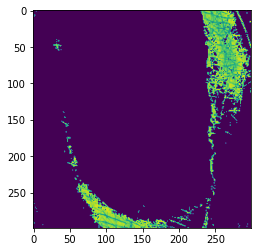

In [ ]:
# Extracting MM mask from image
#from google.colab import drive
#drive.mount('/content/drive/')
# !ls '/content/drive/My Drive/Colab Notebooks'

#import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/isic-2019')
#BASE_PATH = '/content/drive/My Drive/Colab Notebooks/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
#mm = cv2.imread(BASE_PATH + '/' + 'ISIC_0012250.jpg')
mm = cv2.imread('/content/drive/MyDrive/EECS 545/mm_masks/ISIC_0012135.png')

## Read
img = mm

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (120, 0, 0), (255, 255,150))

## slice the green
imask = mask>0
purple = np.zeros_like(img, np.uint8)
purple[imask] = img[imask]

graymask = cv2.cvtColor(purple,cv2.COLOR_BGR2GRAY)

## save 
plt.imshow(cv2.cvtColor(purple,cv2.COLOR_BGR2RGB))
plt.imshow(graymask)

In [ ]:
skinmask = cv2.bitwise_not(cv2.imread('ISIC_0000012_segmentation.png'))
final_mask = cv2.bitwise_and(skinmask, purple)

plt.imshow(final_mask)

In [ ]:
graymask = cv2.cvtColor(final_mask,cv2.COLOR_BGR2GRAY)
thresh1 = cv2.bitwise_not(cv2.threshold(graymask,30,255,cv2.THRESH_BINARY)[1])
#thresh1 = cv2.threshold(graymask,30,255,cv2.THRESH_BINARY)[1]

plt.imshow(thresh1)

no_mm_sub = cv2.bitwise_and(no_mm,no_mm,mask=thresh1)
new_img = cv2.add(no_mm_sub,final_mask)

plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))

## Function Definitions

In [ ]:
def mm_extract(img,skinmask,blue,red):
  ## convert to hsv
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  ## mask of green (36,25,25) ~ (86, 255,255)
  # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
  mask = cv2.inRange(hsv, (blue, 0, 0), (255, 255,red))

  ## slice the green
  imask = mask>0
  purple = np.zeros_like(img, np.uint8)
  purple[imask] = img[imask]

  graymask = cv2.cvtColor(purple,cv2.COLOR_BGR2GRAY)

  skinmask = cv2.bitwise_not(skinmask)
  final_mask = cv2.bitwise_and(skinmask, purple)
  plt.imshow(final_mask)

  return final_mask


def mm_aug(final_mask,no_mm):
  graymask = cv2.cvtColor(final_mask,cv2.COLOR_BGR2GRAY)
  thresh1 = cv2.bitwise_not(cv2.threshold(graymask,30,255,cv2.THRESH_BINARY)[1])

  plt.imshow(thresh1)

  no_mm_sub = cv2.bitwise_and(no_mm,no_mm,mask=thresh1)
  new_img = cv2.add(no_mm_sub,final_mask)

  plt.imshow(cv2.cvtColor(new_img,cv2.COLOR_BGR2RGB))

  return new_img

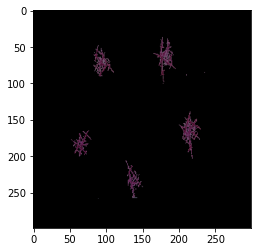

In [ ]:
img =  cv2.imread('ISIC_0013197.png')
skinmask = cv2.imread('ISIC_0000012_segmentation.png')
no_mm = cv2.imread('ISIC_0000012.png')

final_mask = mm_extract(img,skinmask,120,120)

plt.imshow(final_mask)

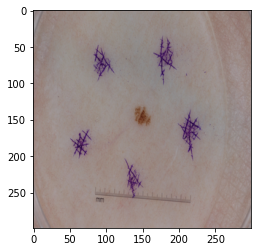

In [ ]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

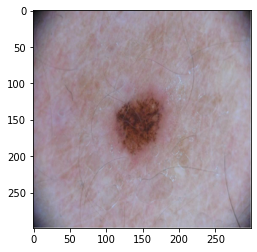

In [ ]:
plt.imshow(cv2.cvtColor(no_mm,cv2.COLOR_BGR2RGB))

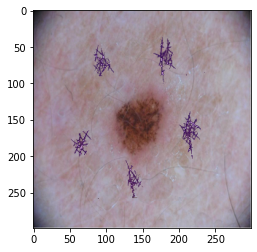

In [ ]:
new_img = mm_aug(final_mask,no_mm)

## Helper function to determine color threshold values

In [ ]:
import cv2

def doNothing(x):
    pass

#creating a resizable window named Track Bars
cv2.namedWindow('Track Bars', cv2.WINDOW_NORMAL)

cv2.createTrackbar('min_blue', 'Track Bars', 0, 255, doNothing)
cv2.createTrackbar('min_green', 'Track Bars', 0, 255, doNothing)
cv2.createTrackbar('min_red', 'Track Bars', 0, 255, doNothing)

cv2.createTrackbar('max_blue', 'Track Bars', 0, 255, doNothing)
cv2.createTrackbar('max_green', 'Track Bars', 0, 255, doNothing)
cv2.createTrackbar('max_red', 'Track Bars', 0, 255, doNothing)



image_path = 'isic-rgb-299/ISIC_0013554.png'
# reading the image
object_image = cv2.imread(image_path)

#resizing the image for viewing purposes
resized_image = cv2.resize(object_image,(299, 299))

#converting into HSV color model
hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

#showing both resized and hsv image in named windows
cv2.imshow('Base Image', resized_image)
cv2.imshow('HSV Image', hsv_image)


#creating a loop to get the feedback of the changes in trackbars
while True:
    #reading the trackbar values for thresholds
    min_blue = cv2.getTrackbarPos('min_blue', 'Track Bars')
    min_green = cv2.getTrackbarPos('min_green', 'Track Bars')
    min_red = cv2.getTrackbarPos('min_red', 'Track Bars')
    
    max_blue = cv2.getTrackbarPos('max_blue', 'Track Bars')
    max_green = cv2.getTrackbarPos('max_green', 'Track Bars')
    max_red = cv2.getTrackbarPos('max_red', 'Track Bars')
    
    #using inrange function to turn on the image pixels where object threshold is matched
    mask = cv2.inRange(hsv_image, (min_blue, min_green, min_red), (max_blue, max_green, max_red))
    #showing the mask image
    cv2.imshow('Mask Image', mask)
    # checking if q key is pressed to break out of loop
    key = cv2.waitKey(25)
    if key == ord('q'):
        break
    
#printing the threshold values for usage in detection application
print(f'min_blue {min_blue}  min_green {min_green} min_red {min_red}')
print(f'max_blue {max_blue}  max_green {max_green} max_red {max_red}')
#destroying all windows
cv2.destroyAllWindows()

## Base Image with no Medical Markings

In [ ]:
no_mm = cv2.imread('ISIC_0000012.png')

plt.imshow(cv2.cvtColor(no_mm,cv2.COLOR_BGR2RGB))

## Applying Medical Markings Augmentation

In [ ]:

all_mm_masks = []

img =  cv2.imread('ISIC_0012250.png')
skinmask = cv2.imread('ISIC_0000012_segmentation.png')
no_mm = cv2.imread('ISIC_0000012.png')

final_mask = mm_extract(img,skinmask,120,120)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_1.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

error: ignored

## Start

In [ ]:
import numpy as np
mm_images = ['ISIC_0012742','ISIC_0012135','ISIC_0012250','ISIC_0013026','ISIC_0013070','ISIC_0013075','ISIC_0013172','ISIC_0013197','ISIC_0013553','ISIC_0013414','ISIC_0013554','ISIC_0010086','ISIC_0012246']
thresh_values = np.array([[120,150],[120,150],[120,150],[120,150],[120,150],[120,150],[120,150],[120,120],[120,150],[120,120],[120,150],[120,150],[120,120]])

#for i in range(len(mm_images)):
#  image_dict = {mm_images[i]:thresh_values[i]}

image_dict = dict(zip(mm_images, thresh_values))

In [ ]:
print(image_dict['ISIC_0012742'])

[120 150]


In [ ]:
img =  cv2.imread('ISIC_0012250.png')


final_mask = mm_extract(img,skinmask,120,150)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_2.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0012135.png')

final_mask = mm_extract(img,skinmask,120,150)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_3.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0012713.png')

final_mask = mm_extract(img,skinmask,120,170)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_4.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0012742.png')

final_mask = mm_extract(img,skinmask,120,150)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_5.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0013070.png')

final_mask = mm_extract(img,skinmask,120,150)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_6.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0013075.png')

final_mask = mm_extract(img,skinmask,120,150)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_7.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0013197.png')

final_mask = mm_extract(img,skinmask,120,120)

plt.imshow(final_mask)

#all_mm_masks.append(final_mask) 
#cv2.imwrite(f'mm_image_8.jpg',final_mask)

#new_img = mm_aug(final_mask,no_mm)

NameError: ignored

In [ ]:
img =  cv2.imread('ISIC_0013414.png')

final_mask = mm_extract(img,skinmask,120,120) #low(120,50,0)high(170,255,130)

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_9.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
img =  cv2.imread('ISIC_0013554.png')

final_mask = mm_extract(img,skinmask,120,150) 

all_mm_masks.append(final_mask) 
cv2.imwrite(f'mm_image_10.jpg',final_mask)

new_img = mm_aug(final_mask,no_mm)

In [ ]:
all_mm_masks = np.array(all_mm_masks)
np.save('mm_array.npy',all_mm_masks.astype(np.uint8))
    
    


## Reference Code

In [ ]:
#extracting hair mask from hairy image
lower_limit = 20# the value that I found helpful

#*********#*********PROCEDURE*********#*********#*********#
###################################
grayScale = cv2.cvtColor(image_resize_hair, cv2.COLOR_RGB2GRAY)

# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the hair countours
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

# intensify the hair countours  
_ ,threshold = cv2.threshold(blackhat,20,255,cv2.THRESH_BINARY)
#######################################
threshold = cv2.bitwise_not(threshold)
plt.imshow(threshold,cmap = 'gray')


In [ ]:
plt.title('no hair image with hair mask on it')
plt.imshow(cv2.bitwise_and(image_resize_no_hair,image_resize_no_hair,mask = threshold))

In [ ]:
# Run this cell to mount Google Drive for Colab
from google.colab import drive
drive.mount('/content/drive/')
# !ls '/content/drive/My Drive/Colab Notebooks'

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/isic-2019')

In [ ]:
!unzip -u "/content/drive/My Drive/Colab Notebooks/isic-2019/ISIC_2019_Training_Input.zip" -d "/content/drive/My Drive/Colab Notebooks/isic-2019/ISIC_2019_Training_Input"

In [ ]:
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
#list of images with hair
#hair_images =['ISIC_0078712','ISIC_0080817','ISIC_0082348','ISIC_0109869','ISIC_0155012','ISIC_0159568','ISIC_0164145','ISIC_0194550','ISIC_0194914','ISIC_0202023','ISIC_0083035','ISIC_0068279','ISIC_0109703','ISIC_0149527']
hair_images = ['ISIC_0030107', 'ISIC_0030169','ISIC_0030167','ISIC_0030218','ISIC_0030234','ISIC_0030132','ISIC_0030127','ISIC_0030120','ISIC_0030097','ISIC_0030072','ISIC_0030167','ISIC_0031222','ISIC_0031180','ISIC_0030524']

In [ ]:
size=1024
for img in hair_images:
    image = cv2.imread(BASE_PATH + '/' + img + '.jpg')
    image_resize = cv2.resize(image,(size,size))
    image_resize = cv2.cvtColor(image_resize,cv2.COLOR_BGR2RGB)
    plt.imshow(image_resize)
    plt.show()

In [ ]:
#Extracting hair masks from images
def img(image_name,lower_limit=20):    
    '''
    Helper Function to help us iterate with our code!!   
    
    
    '''

    image = cv2.imread(BASE_PATH + '/' + image_name + '.jpg')
    image_resize = cv2.resize(image,(size,size))
   
    grayScale = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)
      # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # intensify the hair countours in preparation for the inpainting 
    _ ,threshold = cv2.threshold(blackhat,lower_limit,255,cv2.THRESH_BINARY)
    # inpaint the original image depending on the mask
    final_image = cv2.inpaint(image_resize,threshold,1,cv2.INPAINT_TELEA)
    
    threshold = cv2.bitwise_not(threshold)
    image_resize = cv2.cvtColor(image_resize,cv2.COLOR_BGR2RGB)
    final_image = cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
    
    return image_resize,threshold,final_image

In [ ]:
image_2,hair_mask_2,_ = img(hair_images[1])
plt.title('The second image')
plt.imshow(image_2)
plt.show()

In [ ]:
plt.title('The hair mask of the second image')
plt.imshow(hair_mask_2,cmap = 'binary_r')
plt.show()

In [ ]:
image_1,_,_ = img(hair_images[0]) 
plt.title('The second image')
plt.imshow(image_1)
plt.show()

In [ ]:
for i,img_name in enumerate(hair_images) :
    _,hair_mask,_ = img(img_name)
    plt.title(f'{i},{img_name}')
    plt.imshow(cv2.bitwise_and(image_1,image_1,mask = hair_mask))
    plt.show()

In [ ]:
possible_cands = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]# possible candidates 
all_hair_masks = []
for i,img_id in enumerate(possible_cands):
    _,hair_masks,_ = img(hair_images[img_id])
    all_hair_masks.append(hair_masks) 
    cv2.imwrite(f'image_{i}.jpg',hair_masks)
    print(len(all_hair_masks))

In [ ]:
all_hair_masks = np.array(all_hair_masks)
np.save('hair_array.npy',all_hair_masks.astype(np.uint8))


In [ ]:
#loading the hairs
hairs = np.load('hair_array.npy')
#the random transformations we want to apply on the masks
hair_trans = albu.Compose([
    albu.ShiftScaleRotate(rotate_limit=[-45,45],scale_limit=[-0.1,0.1],
                          shift_limit=[-0.1,0.15],border_mode=3,p=1.)])

In [ ]:
from numpy.random import choice
def hair_mask(hairs,IMAGE_SIZE,p = 0.3):
    chance = np.random.uniform(0,1,1)
    if chance <= p:
        mask_to_chose = choice(np.arange(14), 1,p=[0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.075,0.075,0.075,0.075])[0]
        mask = hairs[mask_to_chose]
        
        mask = hair_trans(image = mask)['image']
        mask = cv2.resize(mask/255,(IMAGE_SIZE,IMAGE_SIZE),cv2.INTER_CUBIC)
        mask[mask == 1.] =  255
        mask[mask != 255.] = 0
    else:
        mask = np.ones((IMAGE_SIZE,IMAGE_SIZE))
    return mask

In [ ]:
msk = hair_mask(hairs,IMAGE_SIZE=256,p=1.).astype(np.uint8)
plt.imshow(msk,cmap = 'binary_r')

In [ ]:
img = no_hair
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))

plt.imshow(cv2.bitwise_and(img,img,mask= msk))

In [ ]:
#Use this in data loader!!
#composition = albu.Compose([albu.ShiftScaleRotate(rotate_limit=[-90,90],scale_limit=[-0.42,0.35],shift_limit=0,border_mode=0,p=0.5),])
#image = composition(image=img)['image']
#msk = hair_mask(hairs,IMAGE_SIZE=256,p=1.).astype(np.uint8)
#image = cv2.bitwise_and(img,img,mask= msk)